In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch import optim
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128), transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

full_train_dataset = OxfordIIITPet(
    root="./data",
    split='trainval',
    target_types='segmentation',
    transform=None, 
    download=True
)

test_dataset = OxfordIIITPet(
    root="./data",
    split='test',
    target_types='segmentation',
    transform=None,
    download=True
)

In [3]:
def normalize(input_image, input_mask, image_transform, mask_transform):
    input_image = image_transform(input_image)
    input_mask = mask_transform(input_mask)
    input_mask = (input_mask * 255).long() - 1 
    return input_image, input_mask

def process_data(dataset, image_transform, mask_transform):
    processed_data = []
    for image, mask in dataset:
        input_image, input_mask = normalize(image, mask, image_transform, mask_transform)
        processed_data.append((input_image, input_mask))
    return processed_data

processed_train_data = process_data(full_train_dataset, image_transform, mask_transform)
processed_test_data = process_data(test_dataset, image_transform, mask_transform)

# Split train_data into train and validation
train_size = int(0.8 * len(processed_train_data))
val_size = len(processed_train_data) - train_size
train_data, val_data = random_split(processed_train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(processed_test_data, batch_size=64, shuffle=False)

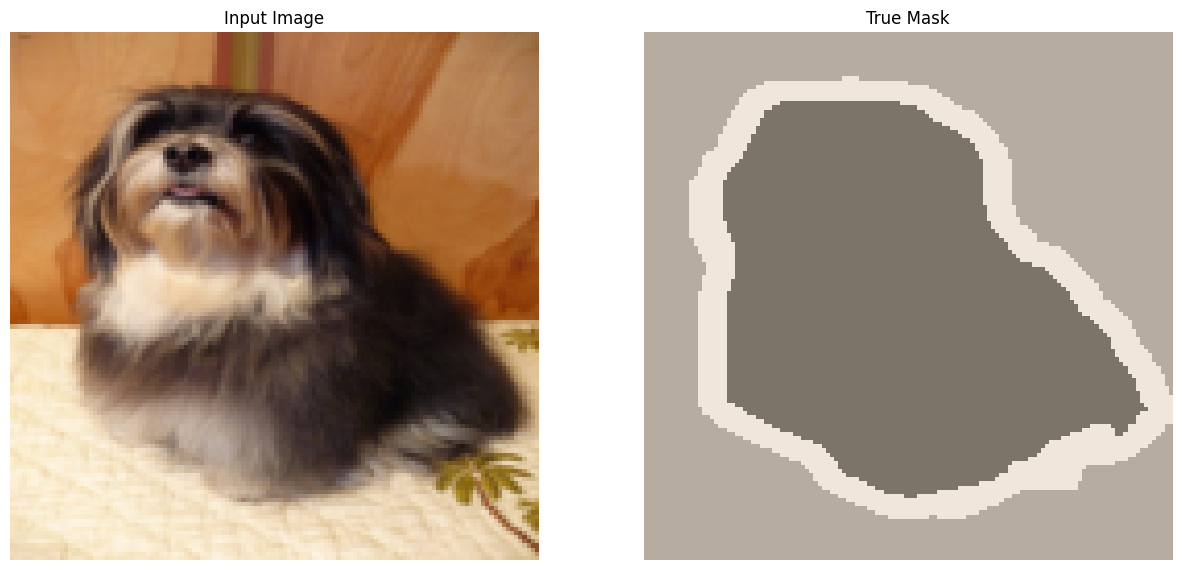

In [4]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        img = display_list[i].cpu().detach()
        img = img.numpy().transpose(1, 2, 0)

        # Denormalize for display if normalization was applied
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1) # Clip values to valid range for display

        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap="gray")
        else:
            plt.imshow(img)
        plt.axis("off")
    plt.show()

sample_batch = next(iter(train_loader))
sample_images, sample_masks = sample_batch
random_index = np.random.randint(sample_images.shape[0])
sample_image = sample_images[random_index]
sample_mask = sample_masks[random_index]

display([sample_image, sample_mask])

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
        self,
        in_channels=3, # N_channels
        out_channels=3, # N_classes
        features=[64, 128, 256, 512],
    ):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode="bilinear", align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1) # along channels
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)
        return F.softmax(x, dim=1)

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA (GPU)")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

model = UNET(in_channels=3, out_channels=3).to(DEVICE)
model = torch.compile(model)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)


Using CUDA (GPU)


/DATA/anaconda3/envs/nanogpt/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_fn(train_loader, model, optimizer, loss_fn, device):
    model.train()
    loop = tqdm.tqdm(train_loader, desc="Training")
    total_loss = 0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.squeeze(1).long().to(device)

        # Forward pass
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update tqdm progress bar
        loop.set_postfix(loss=loss.item())
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def val_fn(val_loader, model, loss_fn, device):
    model.eval()
    loop = tqdm.tqdm(val_loader, desc="Validation")
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device)
            targets = targets.squeeze(1).long().to(device)

            # Forward pass
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
    avg_loss = total_loss / len(val_loader)
    return avg_loss


# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, DEVICE)
    val_loss = val_fn(val_loader, model, loss_fn, DEVICE)
    scheduler.step(val_loss) # Step the scheduler based on validation loss
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 25.38it/s, loss=0.833]


Epoch 1: Train Loss: 0.7682, Val Loss: 0.7964
Epoch [2/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 24.61it/s, loss=0.817]


Epoch 2: Train Loss: 0.7659, Val Loss: 0.7927
Epoch [3/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 25.42it/s, loss=0.801]


Epoch 3: Train Loss: 0.7563, Val Loss: 0.7770
Epoch [4/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 24.70it/s, loss=0.799]


Epoch 4: Train Loss: 0.7515, Val Loss: 0.7766
Epoch [5/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 24.29it/s, loss=0.795]


Epoch 5: Train Loss: 0.7494, Val Loss: 0.7766
Epoch [6/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 22.98it/s, loss=0.798]


Epoch 6: Train Loss: 0.7480, Val Loss: 0.7762
Epoch [7/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 24.94it/s, loss=0.797]


Epoch 7: Train Loss: 0.7464, Val Loss: 0.7760
Epoch [8/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 24.43it/s, loss=0.798]


Epoch 8: Train Loss: 0.7454, Val Loss: 0.7760
Epoch [9/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 24.42it/s, loss=0.796]


Epoch 9: Train Loss: 0.7441, Val Loss: 0.7763
Epoch [10/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 24.84it/s, loss=0.796]


Epoch 10: Train Loss: 0.7427, Val Loss: 0.7766
Epoch [11/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 23.08it/s, loss=0.803]


Epoch 11: Train Loss: 0.7413, Val Loss: 0.7793
Epoch [12/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 26.24it/s, loss=0.797]


Epoch 12: Train Loss: 0.7383, Val Loss: 0.7778
Epoch [13/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 24.91it/s, loss=0.797]


Epoch 13: Train Loss: 0.7379, Val Loss: 0.7767
Epoch [14/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 36.46it/s, loss=0.797]


Epoch 14: Train Loss: 0.7373, Val Loss: 0.7762
Epoch [15/15]


Validation: 100%|██████████| 12/12 [00:00<00:00, 26.51it/s, loss=0.798]

Epoch 15: Train Loss: 0.7374, Val Loss: 0.7765


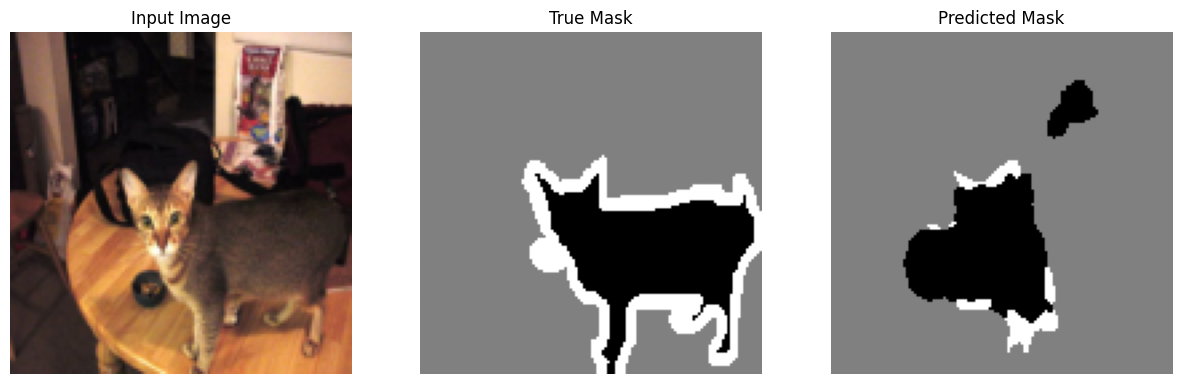

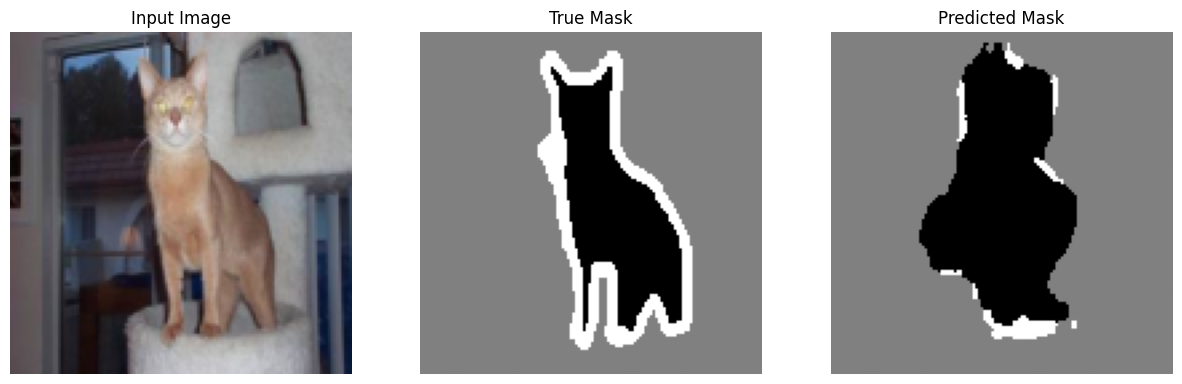

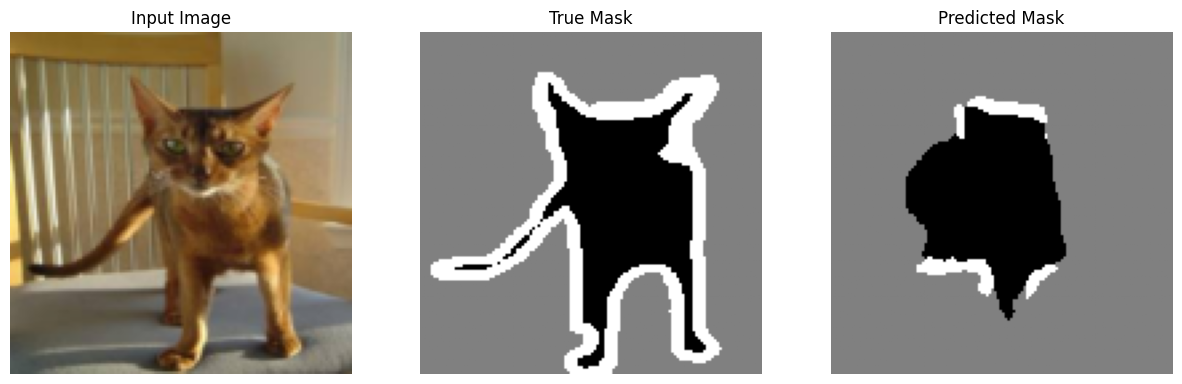

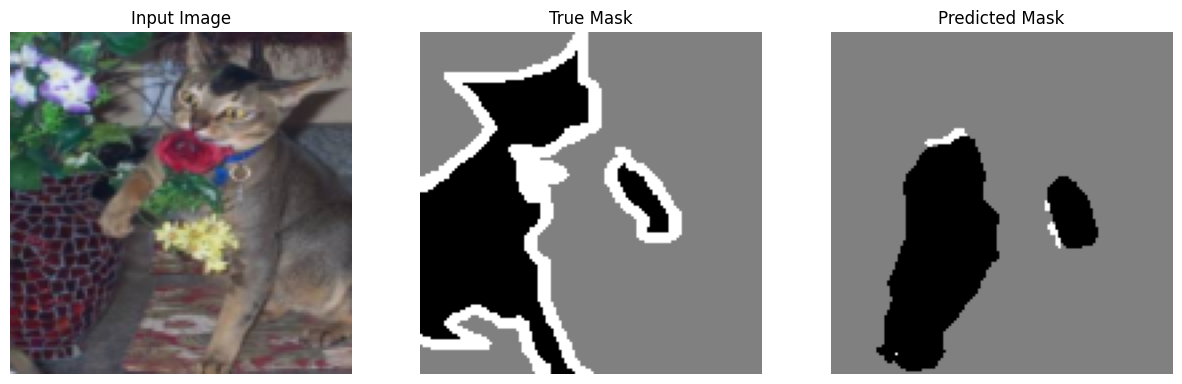

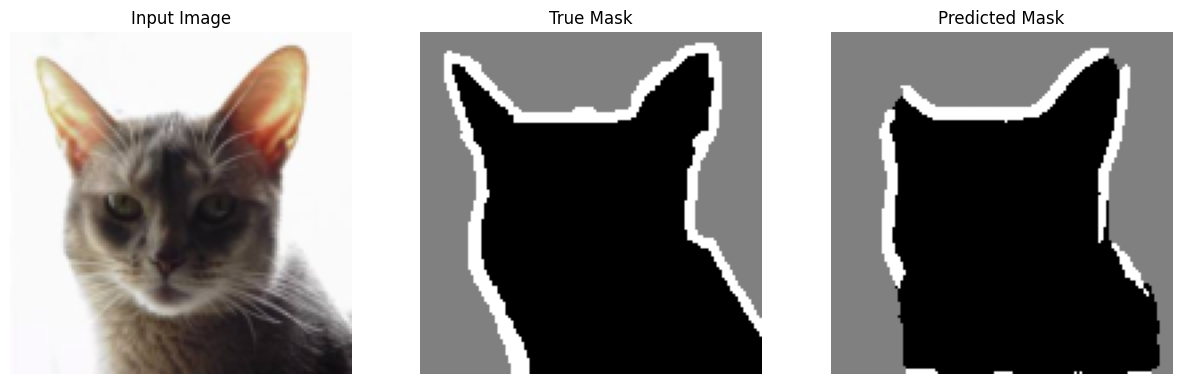

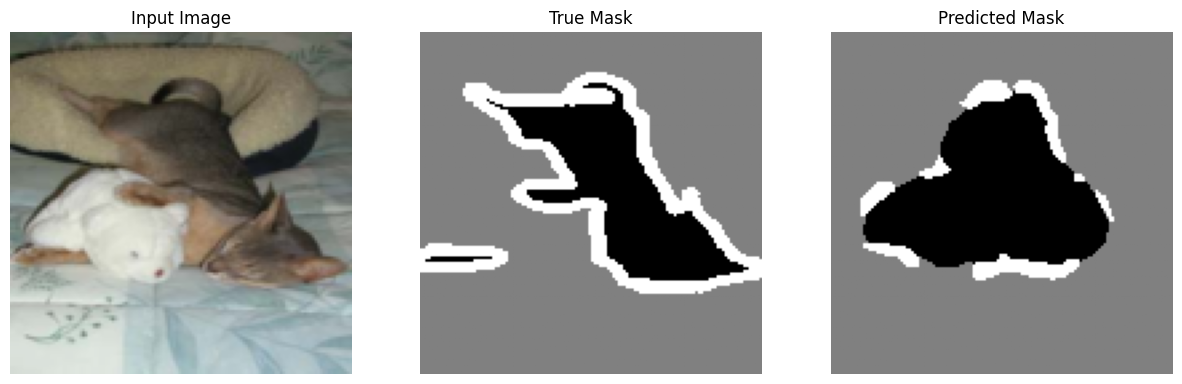

In [13]:
def create_mask(pred_mask):
    """Returns the predicted mask with argmax applied along the channel dimension."""
    pred_mask = torch.argmax(pred_mask, dim=1)
    return pred_mask[0].cpu().numpy() 

def show_predictions(model, dataset, num=1, device="cuda"):
    """Displays input image, true mask, and predicted mask."""
    model.eval()
    with torch.no_grad():
        for i in range(num):
            image, mask = dataset[i]
            image = image.unsqueeze(0).to(device)
            pred_mask = model(image)
            pred_mask = create_mask(pred_mask) 

            image_np = image[0].cpu().permute(1, 2, 0).numpy() # (1,3,128,128) -> (3,128,128) -> (128,128,3)

            # for display
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)

            mask_np = mask[0].cpu().squeeze().numpy()

            display_images([image_np, mask_np, pred_mask])

def display_images(display_list):
    """Displays a list of images with titles."""
    plt.figure(figsize=(15, 5))
    titles = ["Input Image", "True Mask", "Predicted Mask"]
    for i, img in enumerate(display_list):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(titles[i])
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
        plt.axis("off")
    plt.show()

show_predictions(model, processed_test_data, num=6, device=DEVICE)